## Applications of `distmetric`: Genealogies demo
Goal: Applying distmetric to calculate distances between unlinked vs. linked genealogies and comparing the Robinson-Foulds and Quartets method based on reference from McKenzie & Eaton (2020) The Multispecies Coalescent in Space and Time.

In [67]:
import distmetric                           # distance calculations
import toytree                              # tree parsing and drawing trees
import toyplot, toyplot.pdf, toyplot.svg    # generating and rendering plots
import ipcoal                               # simulating genealogies for analysis
import numpy as np                          # statistical analyses
import pandas as pd                         # saving results as data frames

## 1) Simulating unlinked genealogies with ipcoal
- Function to simulate genealogies based on an imbalanced tree and given parameters (number of tips, tree height, number of loci, number of sites and coalescent units). 
- Unlinked genealogies = simulate with 1 site and sample size of 100. 
- Store ipcoal output in dictionary object, where key = parameter label, value = data frame with genealogies.

In [2]:
# provides imbalanced tree for ipcoal to simulate on based on given parameters
# (number of tips, tree height, number of loci, number of sites, coalescent units)
def sim_imb_fixed_t(ntips, height, nloci, nsites, coal, seed=123):
    """
    Return an ipcoal.Model object with genealogies simulated
    for 'nloci' and 'nsites' on an imbalanced 'tree' with Ne auto
    scaled so that all internal edges are 'coal' units long. 
    """
    # generate imbalanced tree
    tree = toytree.rtree.imbtree(ntips=ntips)
    
    # scale stem height 
    tree = tree.mod.node_scale_root_height(treeheight=height, include_stem=True)
    
    # add line to fix coding issue
    tree = tree.mod.make_ultrametric()
    
    # get internode dist
    dist = tree.treenode.dist
    
    # get Ne by scaling coalunits by internode height
    Ne = int(dist / (coal * 2.))
    
    # init model and sim n unlinked genealogies
    model = ipcoal.Model(tree, Ne=Ne, seed=seed)
    
    model.sim_trees(nloci=nloci, nsites=nsites)
    return model.df

In [3]:
# parameters
coalunits = [0.2, 1.0, 2.0]
treesizes = [10, 20, 40]
treeheights = [10000, 100000, 1000000]

sample_size = 100

In [4]:
# generating genealogies for each respective parameter
# to be filled with {jobname: ipcoal.Model().df} DataFrame results
results1 = {}
    

# iterate over internode lengths in coal units
for coal in coalunits:

    # iterate over tree sizes in ntips
    for ntips in treesizes:

        # iterate over tree-heights even though they have NO EFFECT
        for th in treeheights:

            # jobname 
            jobname = "tree-{}-coal-{}-th-{}".format(ntips, coal, th)

            # this will calculate Ne and run simulation
            future = sim_imb_fixed_t(ntips, int(th), sample_size, 1, coal, 123)

            # store future
            results1[jobname] = future  

In [57]:
results1

{'tree-10-coal-0.2-th-10000':     locus  start  end  nbps  nsnps  tidx                    genealogy
 0       0      0    1     1      0     0  ((r5:8580,(r6:6721,(r3:4...
 1       1      0    1     1      0     0  (r7:17391,(r9:13783,(r6:...
 2       2      0    1     1      0     0  ((r8:8652,(r7:7602,(r4:6...
 3       3      0    1     1      0     0  (r9:22463,(r8:20537,(r7:...
 4       4      0    1     1      0     0  ((r8:9998,(r6:7508,(r7:7...
 ..    ...    ...  ...   ...    ...   ...                          ...
 95     95      0    1     1      0     0  ((r7:8828,r8:8828):16077...
 96     96      0    1     1      0     0  ((r4:7542,r7:7542):7115,...
 97     97      0    1     1      0     0  ((r7:9169,r9:9169):2135,...
 98     98      0    1     1      0     0  ((r6:9138,(r1:2484,(r0:2...
 99     99      0    1     1      0     0  ((r6:7957,(r1:6188,(r5:5...
 
 [100 rows x 7 columns],
 'tree-10-coal-0.2-th-100000':     locus  start  end  nbps  nsnps  tidx                    g

## 2) Calculating distances between unlinked genealogies with distmetric
- distmetric reads in newick trees (genealogies from ipcoal simualtion)
- distmetric calculates distance metrics and outputs a data frame
- Taking resulting distance metrics from a data frame -> store as a numpy array for further statistical analyses

In [6]:
# Find pairwise RFs for unlinked genealogies
# store dictionary keys
results1_keys = list(results1.keys())

# new dictionary to store results
rfs_unlinked = {}

# iterate through each key of dictionary to get genealogy column
for key in results1_keys:
    genealogies = list(results1[key]['genealogy'])
    RFS_unlinked = distmetric.RF(genealogies, "pairwise")
    RFS_unlinked.run()
    rfs_unlinked[key] = np.array(RFS_unlinked.output['RF'])

In [8]:
# Find pairwise quartets for unlinked genealogies
# use the same dictionary keys in results1.keys

# new dictionary to store results for quartets
quartets_unlinked = {}

# iterate through each key of dictionary to get genealogy column
for key in results1_keys:
    genealogies = list(results1[key]['genealogy'])
    QUARTETS_unlinked = distmetric.Quartets(genealogies, "pairwise")
    QUARTETS_unlinked.run()
    quartets_unlinked[key] = np.array(QUARTETS_unlinked.output['Quartet_intersection'])

In [7]:
rfs_unlinked

{'tree-10-coal-0.2-th-10000': array([0.33333333, 0.44444444, 0.44444444, 0.33333333, 0.38888889,
        0.27777778, 0.38888889, 0.33333333, 0.38888889, 0.38888889,
        0.44444444, 0.27777778, 0.44444444, 0.38888889, 0.38888889,
        0.38888889, 0.38888889, 0.44444444, 0.44444444, 0.27777778,
        0.44444444, 0.44444444, 0.38888889, 0.38888889, 0.38888889,
        0.44444444, 0.33333333, 0.38888889, 0.38888889, 0.44444444,
        0.44444444, 0.38888889, 0.33333333, 0.44444444, 0.44444444,
        0.44444444, 0.44444444, 0.44444444, 0.38888889, 0.33333333,
        0.44444444, 0.44444444, 0.38888889, 0.44444444, 0.38888889,
        0.44444444, 0.38888889, 0.38888889, 0.38888889, 0.44444444,
        0.44444444, 0.44444444, 0.38888889, 0.44444444, 0.44444444,
        0.44444444, 0.44444444, 0.44444444, 0.38888889, 0.33333333,
        0.44444444, 0.38888889, 0.27777778, 0.38888889, 0.44444444,
        0.38888889, 0.38888889, 0.44444444, 0.44444444, 0.38888889,
        0.44444444,

## 3)  Interpreting unlinked results: pandas and toyplot
- Summarize data with mean and std of RF/Quartet distances
- Two plots to compare between metrics

In [53]:
# create data frame
resdf = pd.DataFrame({
    "ntips": np.repeat(treesizes, len(coalunits) * len(treeheights)),
    "tc": np.tile(np.repeat(coalunits, len(treesizes)), len(treeheights)),
    "height": np.tile(np.tile(treeheights, len(coalunits)), len(treesizes)).astype(int),
    "uRF-mean": 0.,
    "uRF-std": 0.,
    "uQuartets-mean": 0.,
    "uQuartets-std": 0.,
    "block-size": 0,
})

In [54]:
# fill in RF and quartet results

# iterate over each parameter
for ntips in treesizes:
    for coal in coalunits:
        for th in treeheights:

            # get simulation results stored in rfs-unlinked (data frame for RF) 
            # & quartets-unlinked (data frame for quartets)
            jobname = "tree-{}-coal-{}-th-{}".format(ntips, coal, th)
            rf = rfs_unlinked[jobname]
            quartet = quartets_unlinked[jobname]

            # get mask to fill cell for this specific job
            m1 = resdf.tc == coal
            m2 = resdf.height == th
            m3 = resdf.ntips == ntips
            mask = m1 & m2 & m3

            # fill the table with values from off diagonal
            resdf.loc[mask, "uRF-mean"] = np.mean(rf)
            resdf.loc[mask, "uRF-std"] = np.std(rf)
            resdf.loc[mask, "uQuartets-mean"] = np.mean(quartet)
            resdf.loc[mask, "uQuartets-std"] = np.std(quartet)

In [55]:
resdf
# resdf.to_csv('~/Desktop/unlinked-genealogies.csv')

,ntips,tc,height,uRF-mean,uRF-std,uQuartets-mean,uQuartets-std,block-size
0,10,0.2,10000,0.403479,0.047762,0.421549,0.110986,0
1,10,0.2,100000,0.403479,0.047762,0.421549,0.110986,0
2,10,0.2,1000000,0.403479,0.047762,0.420394,0.112237,0
3,10,1.0,10000,0.212682,0.087944,0.780856,0.115678,0
4,10,1.0,100000,0.212682,0.087944,0.780856,0.115678,0
5,10,1.0,1000000,0.212682,0.087944,0.780856,0.115678,0
6,10,2.0,10000,0.084736,0.059795,0.923232,0.061897,0
7,10,2.0,100000,0.083614,0.059288,0.924483,0.061102,0
8,10,2.0,1000000,0.083614,0.059288,0.924483,0.061102,0
9,20,0.2,10000,0.445774,0.028441,0.536340,0.087942,0


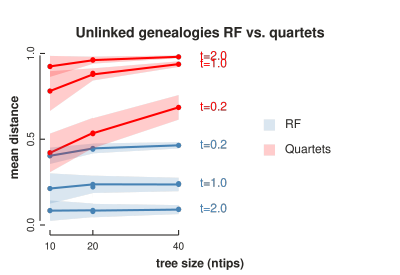

In [122]:
# comparison plot
toyplot.config.autoformat = "html"

# get canvas and axes
canvas = toyplot.Canvas(width=400, height=275);
axes = canvas.cartesian(label="Unlinked genealogies RF vs. quartets", xlabel="tree size (ntips)", ylabel="mean distance",)
axes.x.ticks.show = True
axes.y.ticks.show = True
axes.x.domain.max = 80
axes.x.ticks.locator = toyplot.locator.Explicit((10, 20, 40))

# plot the data markers
for coal in resdf.tc.unique():
    
    # subselect data
    mask = resdf["tc"] == coal
    
    # draw the mean measured points   
    axes.scatterplot(resdf.loc[mask, "ntips"], resdf.loc[mask, "uRF-mean"], color="steelblue")
    axes.scatterplot(resdf.loc[mask, "ntips"], resdf.loc[mask, "uQuartets-mean"], color="red")
    
    # draw the mean connecting lines
    axes.plot(resdf.loc[mask, "ntips"], resdf.loc[mask, "uRF-mean"], color="steelblue")
    axes.plot(resdf.loc[mask, "ntips"], resdf.loc[mask, "uQuartets-mean"], color="red")
    
    # fill a shade to the +-std
    RFfill = axes.fill(resdf.loc[mask, "ntips"], resdf.loc[mask, "uRF-mean"] - resdf.loc[mask, "uRF-std"],
        resdf.loc[mask, "uRF-mean"] + resdf.loc[mask, "uRF-std"], opacity=0.2, color="steelblue")
    quartetfill = axes.fill(resdf.loc[mask, "ntips"], resdf.loc[mask, "uQuartets-mean"] - resdf.loc[mask, "uQuartets-std"],
        resdf.loc[mask, "uQuartets-mean"] + resdf.loc[mask, "uQuartets-std"], opacity=0.2, color="red")
    
    # add labels
    axes.text(resdf.loc[mask, "ntips"].max() + 5, resdf.loc[mask, "uRF-mean"].max(), "t={}".format(coal),
        style={"text-anchor": "start"}, color="steelblue")
    axes.text(resdf.loc[mask, "ntips"].max() + 5, resdf.loc[mask, "uQuartets-mean"].max(), "t={}".format(coal),
        style={"text-anchor": "start"}, color="red")

canvas.legend([("RF", RFfill),("Quartets", quartetfill),], corner=("right", 80, 80, 50),);
#toyplot.svg.render(canvas, "/Users/scarletau/Desktop/unlinked-genealogies.svg")
#toyplot.pdf.render(canvas, "/Users/scarletau/Desktop/unlinked-genealogies.pdf")
canvas

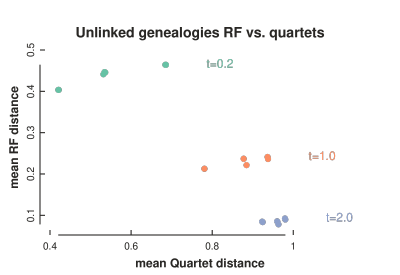

In [147]:
# scatterplot
toyplot.config.autoformat = "html"

# get canvas and axes
canvas2 = toyplot.Canvas(width=400, height=275);
axes2 = canvas2.cartesian(label="Unlinked genealogies RF vs. quartets", xlabel="mean Quartet distance", ylabel="mean RF distance",)
axes2.x.ticks.show = True
axes2.y.ticks.show = True
#axes2.x.domain.max = 5
axes2.x.ticks.locator = toyplot.locator.Explicit((0.4, 0.6, 0.8, 1.0))

# plot the data markers
for coal in resdf.tc.unique():
    
    # subselect data
    mask = resdf["tc"] == coal
    
    # draw the mean measured points   
    axes2.scatterplot(resdf.loc[mask, "uQuartets-mean"], resdf.loc[mask, "uRF-mean"], size=5)
    axes2.text(resdf.loc[mask, "uQuartets-mean"].max() +0.1, resdf.loc[mask, "uRF-mean"].max(), "t={}".format(coal),
        style={"text-anchor": "start"})
toyplot.svg.render(canvas2, "/Users/scarletau/Desktop/unlinked-genealogies-scatterplot.svg")
toyplot.pdf.render(canvas2, "/Users/scarletau/Desktop/unlinked-genealogies-scatterplot.pdf")
canvas2

## Next steps: Linked genealogies
Linked genealogies = simulate with 1 long loci, 100000 sites

In [114]:
# SIMULATE
# to be filled with {jobname: ipcoal.Model().df} DataFrame results
results2 = {}
    

# iterate over internode lengths in coal units
for coal in coalunits:

    # iterate over tree sizes in ntips
    for ntips in treesizes:

        # iterate over tree-heights even though they have NO EFFECT
        for th in treeheights:

            # jobname 
            jobname = "tree-{}-coal-{}-th-{}".format(ntips, coal, th)

            # this will calculate Ne and run simulation
            future = sim_imb_fixed_t(ntips, th, 1, 1e6, coal, 123)

            # store future
            results2[jobname] = future  

In [117]:
# CALCULATE ROBINSON-FOULDS DISTANCES
# Find pairwise RFs for linked genealogies
# store dictionary keys
results2_keys = list(results2.keys())

# new dictionary to store results
rfs_linked = {}

# iterate through each key of dictionary to get genealogy column
for key in results2_keys:
    genealogies = list(results2[key]['genealogy'])
    RFS_linked = distmetric.RF(genealogies, "pairwise")
    RFS_linked.run()
    rfs_linked[key] = np.array(RFS_linked.output['RF'])

In [ ]:
# CALCULATE QUARTET DISTANCES
# Find pairwise quartets for linked genealogies
# use the same dictionary keys in results2.keys

# new dictionary to store results for quartets
quartets_linked = {}

# iterate through each key of dictionary to get genealogy column
for key in results2_keys:
    genealogies = list(results2[key]['genealogy'])
    QUARTETS_linked = distmetric.Quartets(genealogies, "pairwise")
    QUARTETS_linked.run()
    quartets_linked[key] = np.array(QUARTETS_linked.output['Quartet_intersection'])

In [ ]:
# PLOTTING WITH TOYPLOT
# code here depends on type of plot, styling options etc...(exponential decay plot)

## Appendix: All tables

### Unlinked

In [50]:
# unlinked genealogies
results1

{'tree-10-coal-0.2-th-10000':     locus  start  end  nbps  nsnps  tidx                    genealogy
 0       0      0    1     1      0     0  ((r5:8580,(r6:6721,(r3:4...
 1       1      0    1     1      0     0  (r7:17391,(r9:13783,(r6:...
 2       2      0    1     1      0     0  ((r8:8652,(r7:7602,(r4:6...
 3       3      0    1     1      0     0  (r9:22463,(r8:20537,(r7:...
 4       4      0    1     1      0     0  ((r8:9998,(r6:7508,(r7:7...
 ..    ...    ...  ...   ...    ...   ...                          ...
 95     95      0    1     1      0     0  ((r7:8828,r8:8828):16077...
 96     96      0    1     1      0     0  ((r4:7542,r7:7542):7115,...
 97     97      0    1     1      0     0  ((r7:9169,r9:9169):2135,...
 98     98      0    1     1      0     0  ((r6:9138,(r1:2484,(r0:2...
 99     99      0    1     1      0     0  ((r6:7957,(r1:6188,(r5:5...
 
 [100 rows x 7 columns],
 'tree-10-coal-0.2-th-100000':     locus  start  end  nbps  nsnps  tidx                    g

In [51]:
# unlinked RFs
rfs_unlinked

{'tree-10-coal-0.2-th-10000': array([0.33333333, 0.44444444, 0.44444444, 0.33333333, 0.38888889,
        0.27777778, 0.38888889, 0.33333333, 0.38888889, 0.38888889,
        0.44444444, 0.27777778, 0.44444444, 0.38888889, 0.38888889,
        0.38888889, 0.38888889, 0.44444444, 0.44444444, 0.27777778,
        0.44444444, 0.44444444, 0.38888889, 0.38888889, 0.38888889,
        0.44444444, 0.33333333, 0.38888889, 0.38888889, 0.44444444,
        0.44444444, 0.38888889, 0.33333333, 0.44444444, 0.44444444,
        0.44444444, 0.44444444, 0.44444444, 0.38888889, 0.33333333,
        0.44444444, 0.44444444, 0.38888889, 0.44444444, 0.38888889,
        0.44444444, 0.38888889, 0.38888889, 0.38888889, 0.44444444,
        0.44444444, 0.44444444, 0.38888889, 0.44444444, 0.44444444,
        0.44444444, 0.44444444, 0.44444444, 0.38888889, 0.33333333,
        0.44444444, 0.38888889, 0.27777778, 0.38888889, 0.44444444,
        0.38888889, 0.38888889, 0.44444444, 0.44444444, 0.38888889,
        0.44444444,

In [52]:
# unlinked quartets
quartets_unlinked

{'tree-10-coal-0.2-th-10000': array([0.47619048, 0.32857143, 0.38095238, 0.46666667, 0.37619048,
        0.70952381, 0.33809524, 0.41428571, 0.3047619 , 0.44761905,
        0.48571429, 0.63809524, 0.27142857, 0.39047619, 0.34285714,
        0.37619048, 0.41428571, 0.20952381, 0.35238095, 0.51904762,
        0.35714286, 0.32380952, 0.51428571, 0.39047619, 0.52380952,
        0.50952381, 0.7       , 0.4       , 0.37619048, 0.30952381,
        0.34285714, 0.34285714, 0.50952381, 0.46666667, 0.25238095,
        0.23333333, 0.34285714, 0.44761905, 0.49047619, 0.72380952,
        0.36666667, 0.38095238, 0.31428571, 0.40952381, 0.49047619,
        0.33333333, 0.41904762, 0.44761905, 0.33333333, 0.34285714,
        0.41428571, 0.38571429, 0.37142857, 0.3047619 , 0.38095238,
        0.3952381 , 0.52857143, 0.37619048, 0.37142857, 0.62857143,
        0.33809524, 0.34285714, 0.65238095, 0.56190476, 0.28571429,
        0.41428571, 0.65238095, 0.33809524, 0.33333333, 0.4047619 ,
        0.5       ,

### Linked

In [116]:
results2

{'tree-10-coal-0.2-th-10000':     locus   start      end   nbps  nsnps  tidx                    genealogy
 0       0       0     2033   2033      0     0  (r3:20098,(r8:9476,(r9:9...
 1       0    2033    10934   8901      0     1  (r3:20098,(r8:9476,(r9:9...
 2       0   10934    30802  19868      0     2  (r8:9476,(r9:9269,(r3:90...
 3       0   30802    38802   8000      0     3  (r8:9476,(r9:9269,(r3:90...
 4       0   38802    46816   8014      0     4  (r1:20098,(r8:9476,(r9:9...
 ..    ...     ...      ...    ...    ...   ...                          ...
 58      0  924633   962804  38171      0    58  (r8:20418,(((r7:7616,(r5...
 59      0  962804   970923   8119      0    59  (r8:20418,(((r7:7616,(r0...
 60      0  970923   982805  11882      0    60  (((r7:7616,(r0:1098,r1:1...
 61      0  982805   990561   7756      0    61  (((r8:9269,r9:9269):172,...
 62      0  990561  1000000   9439      0    62  (((r9:9269,(r7:8603,r8:8...
 
 [63 rows x 7 columns],
 'tree-10-coal-0.2-th

In [119]:
rfs_linked

{'tree-10-coal-0.2-th-10000': array([0.        , 0.11111111, 0.11111111, 0.33333333, 0.        ,
        0.05555556, 0.11111111, 0.11111111, 0.        , 0.        ,
        0.16666667, 0.27777778, 0.        , 0.16666667, 0.        ,
        0.11111111, 0.05555556, 0.        , 0.        , 0.27777778,
        0.        , 0.05555556, 0.        , 0.        , 0.        ,
        0.05555556, 0.27777778, 0.05555556, 0.11111111, 0.16666667,
        0.05555556, 0.05555556, 0.05555556, 0.22222222, 0.        ,
        0.27777778, 0.16666667, 0.16666667, 0.16666667, 0.        ,
        0.11111111, 0.05555556, 0.33333333, 0.        , 0.44444444,
        0.27777778, 0.11111111, 0.11111111, 0.11111111, 0.33333333,
        0.11111111, 0.27777778, 0.05555556, 0.        , 0.27777778,
        0.16666667, 0.        , 0.        , 0.11111111, 0.11111111,
        0.11111111, 0.16666667]),
 'tree-10-coal-0.2-th-100000': array([0.05555556, 0.11111111, 0.        , 0.11111111, 0.11111111,
        0.11111111, 0.2

In [ ]:
quartets_linked